# Section 5.3 in the book 'Deeplearning with Python" by Francois Challet

    Using a Pretraining Convolutional Network.
    There are two ways to use a pretrained network, feature extraction and fine-tuning
    
    ConvolutionModel = BaseModel           +      classifier 
                       (CNN, MaxPolling)          (Dense Layer before prediction)
                       
    In a pretraining model we take trained BaseModel as they represent the general features/concepts of an image.
    we should avoid taking the classifier because it is specific to the set of the classes model is trained.
    

### 1. INSTANTIATING VGG16 CONVOLUTIONAL BASE.

In [6]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

58892288/58889256 [==============================] - 10s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_____________________________________________________________

### 2. INSTANTIATING VGG16 CONVOLUTIONAL BASE.

    Extracting features of each image using convolutional base and storing them.

In [16]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = './DATA/CATS_DOGS'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'validation')

datagen = ImageDataGenerator(rescale = 1./255)
batch_count = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    generator = datagen.flow_from_directory(
                    directory, target_size=(150, 150), batch_size=batch_size, class_mode='binary'
                )
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_count : (i+1)*batch_count] = features_batch
        labels[i*batch_count : (i+1)*batch_count] = labels_batch
        i += 1
        if i*batch_count >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
train_features = np.reshape(train_features, (2000, 4*4*512))

val_features, val_labels = extract_features(val_dir, 1000)
val_features = np.reshape(val_features, (1000, 4*4*512))

test_features, test_labels = extract_features(test_dir, 1000)
test_features = np.reshape(test_features, (1000, 4*4*512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 2. DENSE CLASSIFIER WITH FEATURES AS INPUT.

    Define an dense Layer and train it on the label(features) extracted from the convolutional Base.
    we see that we have got an accuracy of 90% 
    much better than CNN Network with data augmentation and DropOut Layer.

In [20]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30,
                   batch_size=20, validation_data=(val_features, val_labels))


Epoch 1/30
100/100 [==============================] - 4s 31ms/step - loss: 0.6780 - acc: 0.5880 - val_loss: 0.4562 - val_acc: 0.8230
Epoch 2/30
100/100 [==============================] - 3s 25ms/step - loss: 0.4743 - acc: 0.7582 - val_loss: 0.3733 - val_acc: 0.8480
Epoch 3/30
100/100 [==============================] - 3s 26ms/step - loss: 0.3642 - acc: 0.8393 - val_loss: 0.3310 - val_acc: 0.8730
Epoch 4/30
100/100 [==============================] - 3s 27ms/step - loss: 0.3330 - acc: 0.8622 - val_loss: 0.3071 - val_acc: 0.8720
Epoch 5/30
100/100 [==============================] - 3s 30ms/step - loss: 0.2799 - acc: 0.8997 - val_loss: 0.3101 - val_acc: 0.8590
Epoch 6/30
100/100 [==============================] - 3s 28ms/step - loss: 0.2802 - acc: 0.8944 - val_loss: 0.2766 - val_acc: 0.8870
Epoch 7/30
100/100 [==============================] - 3s 30ms/step - loss: 0.2553 - acc: 0.8994 - val_loss: 0.2674 - val_acc: 0.8870
Epoch 8/30
100/100 [==============================] - 4s 45ms/step - 

<function matplotlib.pyplot.show(close=None, block=None)>

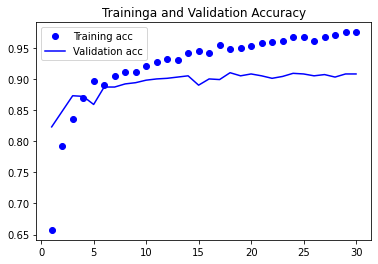

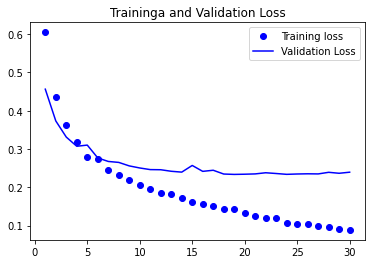

In [21]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Traininga and Validation Accuracy")
plt.legend()

# to plot it in a new figure.
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Traininga and Validation Loss")
plt.legend()

plt.show

### 3. FEATURE EXTRACTION WITH DATA AUGMENTATION.

    They are two ways of achieveing this,
    1. TRAIN THE COMPLETE MODEL -> CONV BASE (VGG16) + DENSE LAYER ->
    2. TRAIN ONLY the DENSE LAYER by freezing the CONVBASE LAYER.
    
    Below shows the model and freezing of CONV_BASE for training.

In [27]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

conv_base2= VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base2.summary()

model2 = models.Sequential()
model2.add(conv_base2)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.summary()


print(len(model2.trainable_weights))
conv_base2.trainable=False
print(len(model2.trainable_weights))

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### 4. TRAIN THE MODEL ON AUGMENTED DATA.

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

train_datagen2 = ImageDataGenerator(rescale = 1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True
                                  )

val_datagen2 = ImageDataGenerator(rescale = 1./255) # Do not augment Validation Data.

train_generator2 = train_datagen2.flow_from_directory(train_dir, 
                                                    target_size = (150, 150), 
                                                    batch_size=20,
                                                    class_mode='binary')
val_generator2 = val_datagen2.flow_from_directory(val_dir, 
                                                target_size = (150, 150), 
                                                batch_size=20,
                                                class_mode='binary')


model2.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

history = model2.fit_generator(train_generator2,
                               steps_per_epoch=100,
                               epochs=30,
                               validation_data=val_generator2,
                               validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/Users/narendra/opt/anaconda3/envs/DeepLearning/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
100/100 [==============================] - 401s 4s/step - loss: 0.6050 - acc: 0.6638 - val_loss: 0.3167 - val_acc: 0.8670
Epoch 2/50
100/100 [==============================] - 421s 4s/step - loss: 0.4394 - acc: 0.7901 - val_loss: 0.2903 - val_acc: 0.8730
Epoch 3/50
100/100 [==============================] - 371s 4s/step - loss: 0.3798 - acc: 0.8286 - val_loss: 0.2864 - val_acc: 0.8740
Epoch 4/50
100/100 [==============================] - 360s 4s/step - loss: 0.3756 - acc: 0.8202 - val_loss: 0.2571 - val_acc: 0.8920
Epoch 5/50
100/100 [==============================] - 361s 4s/step - loss: 0.3608 - acc: 0.8486 - val_loss: 0.3231 - val_acc: 0.8510
Epoch 6/50
100/100 [==============================] - 30511s 308s/step - loss: 0.3338 - acc: 0.8451 - val_loss: 0.2527 - val_acc: 0.9040
Epoch 7/50
100/100 [==============================] - 495s 5s/step - loss: 0.3355 - acc: 0.8523 - val_loss: 0.4762 - val_acc: 0.7940
Epoch 8/50
100/100 [==============================] - 482s 5s/ste